# Complex - Two Model - Model Selection & Performance Evaluation

Exploratory Data Analysis, Preprocessing, and Feature Selection have been completed. Now with some effort trying to build a good model. Will also evaluate final performance metrics on a holdout.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white") # white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
import sklearn
import xgboost as xgb
from sklift.metrics import auqc, auuc, uplift_at_k
from sklift.viz import plot_uplift_preds, plot_uplift_qini_curves
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

%matplotlib inline

Using TensorFlow backend.


In [2]:
#will summarize the different model scores
def summarize_classification(y_test, y_pred):
    roc_auc = roc_auc_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred, normalize=True)
    num_acc = accuracy_score(y_test, y_pred, normalize=False)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    return {'accuracy': acc,
            'accuracy_count':num_acc,
           'precision':prec,
           'recall':recall,
           'roc_auc':roc_auc}

In [3]:
#helper to train the models
def build_model(classifier_fn,
               name_of_y_col,
               name_of_x_cols,
               dataset,
               test_frac=0.2,
               sample_option=1, #1 nothing, 2 undersample
               random_state_num=None):
    X = dataset[name_of_x_cols]
    Y = dataset[name_of_y_col]
    
    x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=test_frac,random_state=random_state_num)
    
    if sample_option==2:
        #Undersample for class balance
        rm = RandomUnderSampler(random_state=847,sampling_strategy=1)
        x_train, y_train = rm.fit_sample(x_train, y_train)
        x_train = pd.DataFrame(x_train, columns=feature_names)
        y_train = pd.Series(y_train)
        
    
    model = classifier_fn(x_train, y_train)
    
    y_pred = model.predict(x_test)
    
    y_pred_train = model.predict(x_train)
    
    train_summary = summarize_classification(y_train, y_pred_train)
    test_summary = summarize_classification(y_test, y_pred)
    
    pred_results = pd.DataFrame({'y_test': y_test,
                                'y_pred': y_pred})
    
    model_crosstab = pd.crosstab(pred_results.y_pred,pred_results.y_test)
    
    return {'training': train_summary,
           'test': test_summary,
           'confusion_matrix': model_crosstab}

In [4]:
#helper to compare results across different models
def compare_results():
    for key in result_dict:
        print('Classification: ', key)
        print()
        
        print('Training data')
        
        for score in result_dict[key]['training']:
            print(score, result_dict[key]['training'][score])
        print()
        
        print('Test data')
        for score in result_dict[key]['test']:
            print(score, result_dict[key]['test'][score])
        print()

In [5]:
result_dict = {}

In [6]:
filepath = '/nas/isg_prodops_work/stemr/2020/2020_03 - Capstone Project/'

In [7]:
complex_df = pd.read_pickle(filepath + 'complex_df_kitchensink.pkl')

In [8]:
complex_df.head(10)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_319,feature_320,feature_321,response_cont,exposed,true_lift,response_cont_prior,conversion,conversion_post,segments
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,52.494480,87.617843,79.344447,6.227578,1,0.517425,5.710153,0,0,lost_cause
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,68.604182,97.501798,99.512328,7.969111,1,0.023935,7.945175,0,0,lost_cause
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,84.702458,9.173619,59.228162,6.913087,1,-0.152632,7.065719,0,0,lost_cause
3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,34.079220,12.530019,51.666605,11.070399,1,0.815238,10.255161,0,0,lost_cause
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,51.406217,98.320884,74.114424,10.602446,1,2.000000,8.602446,0,0,lost_cause
5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,6.799969,85.677162,35.130002,9.091234,1,1.007653,8.083581,0,0,lost_cause
6,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,56.865584,50.797071,38.965559,8.304548,0,-0.000000,8.304548,0,0,lost_cause
7,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,40.836731,5.532491,60.545716,12.829080,1,2.000000,10.829080,0,1,persuadable
8,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,75.659524,51.845419,48.593962,8.519900,1,-2.000000,10.519900,0,0,lost_cause
9,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,89.610253,4.433208,90.740719,6.059328,0,0.000000,6.059328,0,0,lost_cause


In [9]:
complex_df['segments'] = complex_df['segments'].astype('str')
cat_columns = complex_df.select_dtypes(['category']).columns
complex_df[cat_columns] = complex_df[cat_columns].apply(lambda x: x.cat.codes)

In [10]:
complex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Columns: 329 entries, feature_0 to segments
dtypes: float64(73), int64(50), int8(205), object(1)
memory usage: 2.2+ GB


In [11]:
#holdout for final performance eval
dev_df, holdout_df = train_test_split(complex_df, test_size=0.05)

In [12]:
holdout_df.shape

(100000, 329)

In [13]:
feature_names = list(pd.read_csv(filepath + 'complex_df_feat_names.csv')['feature'])
target_name = 'conversion_post'

In [14]:
len(feature_names)

149

In [15]:
# For two model approach break out in to two datasets one for exposed and one for not exposed
treatment_df = dev_df[dev_df['exposed'] == 1]
control_df = dev_df[dev_df['exposed'] == 0]

In [16]:
## Treatment Test Train Split
x = treatment_df[feature_names]
y = treatment_df[target_name]

x_train_t, x_test_t, y_train_t, y_test_t = train_test_split(x, y, test_size=0.2)

In [17]:
y_train_t.value_counts()

0    1016350
1     123730
Name: conversion_post, dtype: int64

In [18]:
#under to balance
rm = RandomUnderSampler(random_state=847,sampling_strategy=1)
x_train_t, y_train_t = rm.fit_sample(x_train_t, y_train_t)
x_train_t = pd.DataFrame(x_train_t, columns=feature_names)
y_train_t = pd.Series(y_train_t)

In [19]:
x_train_t.shape

(247460, 149)

In [20]:
y_train_t.value_counts()

1    123730
0    123730
Name: conversion_post, dtype: int64

In [66]:
#RandomCV for treatment xgboost
params = {
        'learning_rate' : [.02, .05, .08, .1, .15, .3, .6],
        'min_child_weight': [1, 3, 5, 8, 10],
        'gamma': [0, 0.5, 1, 1.5, 2, 5, 7, 9],
        'subsample': [0.1, 0.4, 0.6, 0.8],
        'colsample_bytree': [0.3,0.6, 0.8],
        'max_depth': [3,5,7,10,15,25,35,40,50],
        'lambda': [0, 0.5, 1, 1.5, 2, 5, 7, 9],
        'alpha': [0, 0.5, 1, 1.5, 2, 5, 7, 9],
        'early_stopping_rounds' : [5,10,15],
        }

xgb = XGBClassifier(objective='binary:logistic', eval_metric='auc', silent=True)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=120, cv=3,
                                   random_state=847, return_train_score=True, n_jobs = 10)
random_search.fit(x_train_t,y_train_t)
random_search.best_params_

{'subsample': 0.6,
 'min_child_weight': 3,
 'max_depth': 5,
 'learning_rate': 0.3,
 'lambda': 1.5,
 'gamma': 0.5,
 'early_stopping_rounds': 15,
 'colsample_bytree': 0.3,
 'alpha': 9}

In [27]:
#default logistic
def logistic_fn(x_train, y_train):
    model = LogisticRegression(solver='liblinear')
    model.fit(x_train,y_train)
    
    return model

In [28]:
#default randomforest
def randomforest_fn(x_train, y_train):
    model = RandomForestClassifier(n_estimators=100,max_depth=10)
    model.fit(x_train,y_train)
    
    return model

In [29]:
#Default xgb
def xgb_fn(x_train, y_train):
    model = XGBClassifier(objective='binary:logistic')
    model.fit(x_train,y_train)
    
    return model

In [30]:
#tuned xgb
def xgb_tuned_fn(x_train, y_train):
    model = XGBClassifier(objective='binary:logistic', eval_metric='auc', subsample=0.6, min_child_weight = 3, max_depth = 5,
                          learning_rate = 0.3, reg_lambda=1.5, gamma = 0.5, early_stopping_rounds=15,  colsample_bytree=0.3, reg_alpha = 9, silent=True)
    model.fit(x_train,y_train)
    
    return model

In [31]:
result_dict['converted ~ logistic'] = build_model(logistic_fn,
                                                target_name,
                                                feature_names,
                                                treatment_df,
                                                test_frac=0.2,
                                                sample_option=2,
                                                random_state_num=847)


result_dict['converted ~ randomforest'] = build_model(randomforest_fn,
                                                target_name,
                                                feature_names,
                                                treatment_df,
                                                test_frac=0.2,
                                                sample_option=2,
                                                random_state_num=847)


result_dict['converted ~ xgb_classifier'] = build_model(xgb_fn,
                                                target_name,
                                                feature_names,
                                                treatment_df,
                                                test_frac=0.2,
                                                sample_option=2,
                                                random_state_num=847)


result_dict['converted ~ xgb_classifier_tuned'] = build_model(xgb_tuned_fn,
                                                target_name,
                                                feature_names,
                                                treatment_df,
                                                test_frac=0.2,
                                                sample_option=2,
                                                random_state_num=847)

compare_results()

Classification:  converted ~ logistic

Training data
accuracy 0.814635207307937
accuracy_count 202256
precision 0.805452369966607
recall 0.8296667445363665
roc_auc 0.8146352073079369

Test data
accuracy 0.80156212718775
accuracy_count 228442
precision 0.33183208590953467
recall 0.8299853491779261
roc_auc 0.8140570954462036

Classification:  converted ~ randomforest

Training data
accuracy 0.7716309942886603
accuracy_count 191579
precision 0.7568673156908451
recall 0.8003689412674502
roc_auc 0.7716309942886602

Test data
accuracy 0.7277435472778565
accuracy_count 207404
precision 0.2523953898648863
recall 0.7778609799772098
roc_auc 0.7497753820568287

Classification:  converted ~ xgb_classifier

Training data
accuracy 0.7828442310635658
accuracy_count 194363
precision 0.7682434910157683
recall 0.8100596911526595
roc_auc 0.7828442310635658

Test data
accuracy 0.7572351892658142
accuracy_count 215809
precision 0.2817959072553201
recall 0.8087904932443432
roc_auc 0.7798991183231638

Classi

In [21]:
## Treatment Test Train Split
x = control_df[feature_names]
y = control_df[target_name]

x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(x, y, test_size=0.2)

In [22]:
y_train_c.value_counts()

0    368356
1     11563
Name: conversion_post, dtype: int64

In [23]:
#under to balance
rm = RandomUnderSampler(random_state=847,sampling_strategy=1)
x_train_c, y_train_c = rm.fit_sample(x_train_c, y_train_c)
x_train_c = pd.DataFrame(x_train_c, columns=feature_names)
y_train_c = pd.Series(y_train_c)

In [24]:
y_train_c.value_counts()

1    11563
0    11563
Name: conversion_post, dtype: int64

In [67]:
#RandomCV for control xgboost
params = {
        'learning_rate' : [.02, .05, .08, .1, .15, .3, .6],
        'min_child_weight': [1, 3, 5, 8, 10],
        'gamma': [0, 0.5, 1, 1.5, 2, 5, 7, 9, 10, 15, 20],
        'subsample': [0.3, 0.4, 0.5, 0.6, 0.7],
        'colsample_bytree': [0.3, 0.5, 0.6, 0.7],
        'max_depth': [3,5,7,10,15,25,30,40],
        'lambda': [0, 0.5, 1, 1.5, 2, 5, 7, 9],
        'alpha': [0, 0.5, 1, 1.5, 2, 5, 7, 9],
        'early_stopping_rounds' : [5,10],
        }

xgb = XGBClassifier(objective='binary:logistic', eval_metric='auc', silent=True)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=120, cv=3,
                                   random_state=847, return_train_score=True, n_jobs = 10)
random_search.fit(x_train_c,y_train_c)
random_search.best_params_

{'subsample': 0.6,
 'min_child_weight': 1,
 'max_depth': 3,
 'learning_rate': 0.3,
 'lambda': 2,
 'gamma': 7,
 'early_stopping_rounds': 5,
 'colsample_bytree': 0.3,
 'alpha': 1}

In [36]:
#default logistic
def logistic_fn(x_train, y_train):
    model = LogisticRegression(solver='liblinear')
    model.fit(x_train,y_train)
    
    return model

In [37]:
#default randomforest
def randomforest_fn(x_train, y_train):
    model = RandomForestClassifier(n_estimators=100,max_depth=10)
    model.fit(x_train,y_train)
    
    return model

In [38]:
#Default xgb
def xgb_fn(x_train, y_train):
    model = XGBClassifier(objective='binary:logistic')
    model.fit(x_train,y_train)
    
    return model

In [39]:
#tuned xgb
def xgb_tuned_fn(x_train, y_train):
    model = XGBClassifier(objective='binary:logistic', eval_metric='auc', subsample=0.6, min_child_weight = 1, max_depth = 3,
                          learning_rate = 0.3, reg_lambda=2, gamma = 7, early_stopping_rounds=5,  colsample_bytree=0.3, reg_alpha = 1, silent=True)
    model.fit(x_train,y_train)
    
    return model

In [40]:
result_dict['converted ~ logistic'] = build_model(logistic_fn,
                                                target_name,
                                                feature_names,
                                                control_df,
                                                test_frac=0.2,
                                                sample_option=2,
                                                random_state_num=847)


result_dict['converted ~ randomforest'] = build_model(randomforest_fn,
                                                target_name,
                                                feature_names,
                                                control_df,
                                                test_frac=0.2,
                                                sample_option=2,
                                                random_state_num=847)


result_dict['converted ~ xgb_classifier'] = build_model(xgb_fn,
                                                target_name,
                                                feature_names,
                                                control_df,
                                                test_frac=0.2,
                                                sample_option=2,
                                                random_state_num=847)


result_dict['converted ~ xgb_classifier_tuned'] = build_model(xgb_tuned_fn,
                                                target_name,
                                                feature_names,
                                                control_df,
                                                test_frac=0.2,
                                                sample_option=2,
                                                random_state_num=847)

compare_results()

Classification:  converted ~ logistic

Training data
accuracy 0.8833653678140835
accuracy_count 20222
precision 0.8723693143245078
recall 0.898130351214398
roc_auc 0.8833653678140836

Test data
accuracy 0.8632282511446766
accuracy_count 82011
precision 0.1706950614058009
recall 0.8973214285714286
roc_auc 0.879735823143065

Classification:  converted ~ randomforest

Training data
accuracy 0.8934999126332344
accuracy_count 20454
precision 0.8730947647448641
recall 0.920845710291805
roc_auc 0.8934999126332344

Test data
accuracy 0.7826430187884849
accuracy_count 74355
precision 0.10798267326732673
recall 0.8389423076923077
roc_auc 0.809902565571258

Classification:  converted ~ xgb_classifier

Training data
accuracy 0.8588153066573475
accuracy_count 19660
precision 0.8398709036742801
recall 0.8866853049100122
roc_auc 0.8588153066573475

Test data
accuracy 0.8138308510078417
accuracy_count 77318
precision 0.12743960865399162
recall 0.8677884615384616
roc_auc 0.8399565807849758

Classificat

## Use winning models to make predictions and generate uplift score



In [25]:
pred_df = holdout_df.reset_index(drop=True)
x_pred_df = pred_df.iloc[:,1:10]
important_columns = feature_names + ['exposed','true_lift','conversion_post', 'segments']
pred_df = pred_df[important_columns]
x_pred_df = pred_df[feature_names] 

In [26]:
def xgb_tuned_fn_t(x_train, y_train):
    model = LogisticRegression(solver='liblinear')
    model.fit(x_train,y_train)
    
    return model

#tuned xgb
def xgb_tuned_fn_c(x_train, y_train):
    model = LogisticRegression(solver='liblinear')
    model.fit(x_train,y_train)
    
    return model

xgb_t = xgb_tuned_fn_t(x_train_t,y_train_t)
xgb_c = xgb_tuned_fn_c(x_train_c,y_train_c)
pred_t = pd.DataFrame(xgb_t.predict_proba(x_pred_df)).iloc[:,1]
pred_c = pd.DataFrame(xgb_c.predict_proba(x_pred_df)).iloc[:,1]

In [27]:
pred_df['treatment_prediction'] = pred_t
pred_df['control_prediction'] = pred_c
pred_df['uplift_prediction'] = pred_df['treatment_prediction'] - pred_df['control_prediction'] 
pred_df['random_prediction'] = pd.DataFrame(np.random.uniform(-1,1,len(pred_df['conversion_post'])))

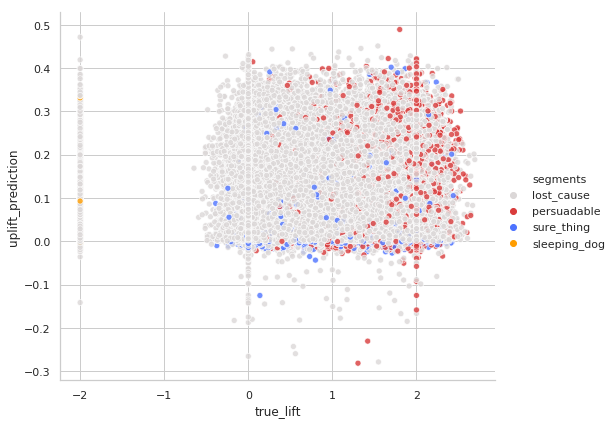

In [30]:
my_pal = {"sure_thing": "#4d73ff", "lost_cause": "#dbd7d7", "persuadable":"#d93b3b", "sleeping_dog":'#ff9d00'}
sns.relplot(x="true_lift", y="uplift_prediction",
            hue="segments",palette=my_pal, data=pred_df, height=6, aspect=1.2, alpha=0.80);

## Performance Evaluation for Two Model

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faeead8a908>,
      dtype=object)

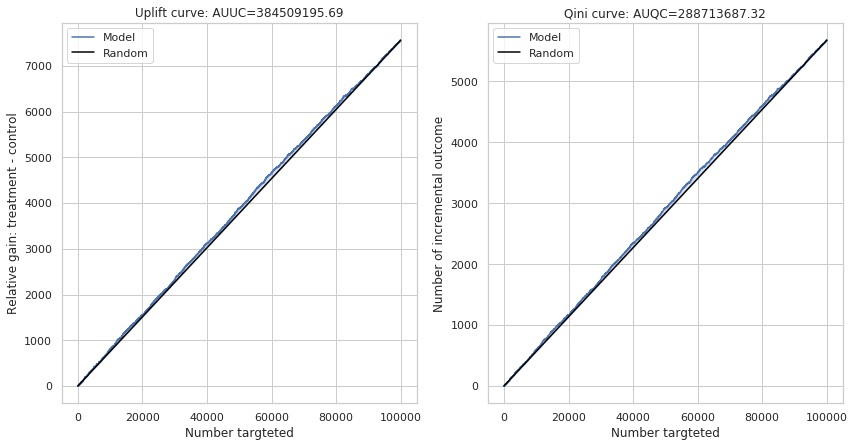

In [45]:
plot_uplift_qini_curves(y_true=pred_df['conversion_post'], uplift=pred_df['random_prediction'], treatment=pred_df['exposed'])

In [46]:
uplift_at_k(y_true=pred_df['conversion_post'], uplift=pred_df['uplift_prediction'], treatment=pred_df['exposed'], k=0.3)

0.11116081442641429

In [47]:
auuc(y_true=pred_df['conversion_post'], uplift=pred_df['uplift_prediction'], treatment=pred_df['exposed'])

450945095.0567508

In [48]:
auqc(y_true=pred_df['conversion_post'], uplift=pred_df['uplift_prediction'], treatment=pred_df['exposed'])

338600692.4961661

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faeeac60d30>,
      dtype=object)

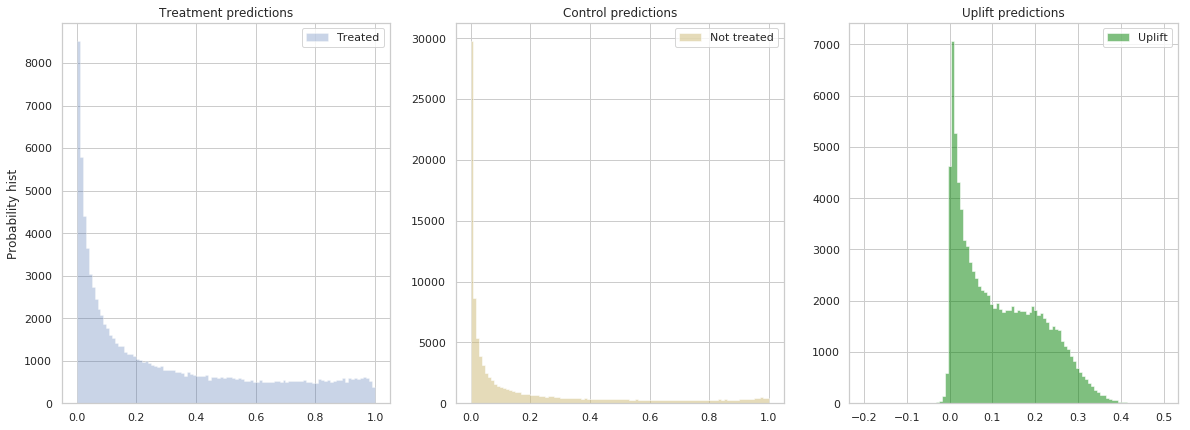

In [49]:
plot_uplift_preds(trmnt_preds=pred_df['treatment_prediction'], ctrl_preds=pred_df['control_prediction'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faeeab7c550>,
      dtype=object)

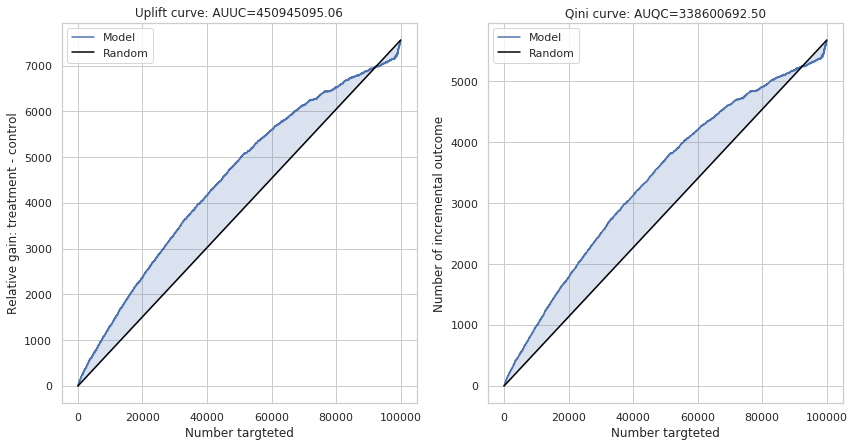

In [50]:
plot_uplift_qini_curves(y_true=pred_df['conversion_post'], uplift=pred_df['uplift_prediction'], treatment=pred_df['exposed'])

In [51]:
pred_df['conversion_post'] = pred_df['conversion_post'].astype('int')

In [52]:
##Assumptions 
budget = 20000 #budget per 100,000 customers
conversion_profit = 500 #Typical profit generated from a sale
cost_per_ad = 4 #cost to treat a customer with an advertisment
treatment_total = int(budget/cost_per_ad)

random_df = pred_df[pred_df["exposed"] == 1].sample(treatment_total, random_state=847)
prediction_df = pred_df[pred_df["exposed"] == 1].sort_values("uplift_prediction",ascending=False).head(treatment_total)

random_p_count = random_df[random_df['segments']=='persuadable']['conversion_post'].sum()
prediction_p_count = prediction_df[prediction_df['segments']=='persuadable']['conversion_post'].sum()
if treatment_total <= pred_df[pred_df['segments']=='persuadable']['conversion_post'].sum():
    perfect_p_count = treatment_total
else:
    perfect_p_count = pred_df[pred_df['segments']=='persuadable']['conversion_post'].sum()
    
    
random_roi = (random_p_count*conversion_profit)- budget
prediction_roi = (prediction_p_count*conversion_profit)- budget
perfect_roi = (perfect_p_count*conversion_profit)- budget
        
print('Treatment Total: {:0,.0f}'.format(treatment_total))
print('Random ROI: ${:0,.0f}'.format(random_roi))
print('Model ROI: ${:0,.0f}'.format(prediction_roi))
print('Perfect ROI: ${:0,.0f}'.format(perfect_roi))

print('Improvement from random: {:.2f}%'.format(((prediction_roi-random_roi)/random_roi)*100))
print('Incremental conversions from random: {}'.format(prediction_p_count-random_p_count))
print('Model to perfect ratio: {:.2f}%'.format((prediction_roi/perfect_roi)*100))

Treatment Total: 5,000
Random ROI: $170,000
Model ROI: $334,000
Perfect ROI: $2,480,000
Improvement from random: 96.47%
Incremental conversions from random: 328
Model to perfect ratio: 13.47%


In [53]:
rand1 = pred_df[pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.75)]
rand2 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.75))  & 
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.50))]
rand3 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.50))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.25))]
rand4 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.25))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.0))]

rand1_p_count = len(rand1[rand1['segments']=='persuadable'])/len(rand1['segments'])
rand2_p_count = len(rand2[rand2['segments']=='persuadable'])/len(rand2['segments'])
rand3_p_count = len(rand3[rand3['segments']=='persuadable'])/len(rand3['segments'])
rand4_p_count = len(rand4[rand4['segments']=='persuadable'])/len(rand4['segments'])

random_rates = pd.DataFrame([rand1_p_count,rand2_p_count,rand3_p_count,rand4_p_count],columns=['random_rate'])

In [54]:
uplift1 = pred_df[pred_df['uplift_prediction'] > pred_df['uplift_prediction'].quantile(q=.75)]
uplift2 = pred_df[(pred_df['uplift_prediction'] <= pred_df['uplift_prediction'].quantile(q=.75))  & 
                  (pred_df['uplift_prediction'] > pred_df['uplift_prediction'].quantile(q=.50))]
uplift3 = pred_df[(pred_df['uplift_prediction'] <= pred_df['uplift_prediction'].quantile(q=.50))  &
                  (pred_df['uplift_prediction'] > pred_df['uplift_prediction'].quantile(q=.25))]
uplift4 = pred_df[(pred_df['uplift_prediction'] <= pred_df['uplift_prediction'].quantile(q=.25))  &
                  (pred_df['uplift_prediction'] > pred_df['uplift_prediction'].quantile(q=.0))]

uplift1_p_count = len(uplift1[uplift1['segments']=='persuadable'])/len(uplift1['segments'])
uplift2_p_count = len(uplift2[uplift2['segments']=='persuadable'])/len(uplift2['segments'])
uplift3_p_count = len(uplift3[uplift3['segments']=='persuadable'])/len(uplift3['segments'])
uplift4_p_count = len(uplift4[uplift4['segments']=='persuadable'])/len(uplift4['segments'])
uplift_rates = pd.DataFrame([uplift1_p_count,uplift2_p_count,uplift3_p_count,uplift4_p_count],columns=['uplift_rate'])

In [55]:
persuade_rate_df = pd.merge(random_rates,uplift_rates, left_index=True, right_index=True)
persuade_rate_df = persuade_rate_df.reset_index()

In [56]:
persuade_rate_df2 = pd.melt(persuade_rate_df, id_vars='index', value_vars=['random_rate','uplift_rate'])
persuade_rate_df2 = persuade_rate_df2.rename(columns={'index':'quartile','value':'persuadable_rate','variable':'prediction'})

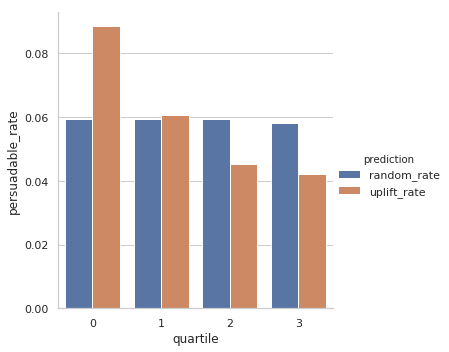

In [57]:
sns.catplot(x='quartile', y='persuadable_rate', hue='prediction', data=persuade_rate_df2, kind='bar');